## Explore Parent Education

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from tools.utils import combine_columns, compute_feature_importance, standard_units

In [3]:
data = pd.read_csv("data/Most-Recent-Cohorts-Institution-filtered.csv").drop('Unnamed: 0', axis=1)

* ```PAR_ED_PCT_MS``` is the percentage of parents who have a middle school education

* ```PAR_ED_PCT_HS``` is the percentage of parents who have a high school education

* ```PAR_ED_PCT_PS``` is the percentage of parents who have some college school education

Only about 10% of these columns' values are null, so we can trust our analysis of these variables with greater certainty.

However, note that the null values occur for exactly the same rows, meaning that they likely share some trait or may come from a different generating distribution. We will drop these values for now as they represent a minority of the dataset

In [4]:
prop_null = data.PAR_ED_PCT_MS.isna().sum() / len(data.PAR_ED_PCT_MS)
null_MS = data.PAR_ED_PCT_MS.isna().sum()
null_HS = data.PAR_ED_PCT_HS.isna().sum()
null_PS = data.PAR_ED_PCT_PS.isna().sum()
print("prop null: ", prop_null)

#each column has the same number of nulls.
print("number of nulls for MS, HS, college (PS) respectively: ", null_MS, null_HS, null_PS)

prop null:  0.11824577159107919
number of nulls for MS, HS, college (PS) respectively:  790 790 790


In [5]:
#each column has nulls in the exact same row as the other columns
null_count = data[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].isna().apply(all, axis=1).sum()
print(f"All 3 columns have {null_count} overlapping nulls")

All 3 columns have 790 overlapping nulls


There are also "PrivacySuppressed" values which act as null values. They still represent a minority of the dataset so we will continue our analysis. 

In [6]:
print("proportion of PAR_ED_PCT_PS which is PrivacySuppressed: ", data.PAR_ED_PCT_PS.str.match("PrivacySuppressed").sum() / len(data))

proportion of PAR_ED_PCT_PS which is PrivacySuppressed:  0.11465349498578058


Note that once again these null-like values contain a pattern. Rows which are "PrivacySuppressed" for college education ```PAR_ED_PCT_PS``` tend to be privacy suppressed in highschool education ```PAR_ED_PCT_HS``` and middle school education ```PAR_ED_PCT_PS```. Similarly, rows which are "PrivacySuppressed" for highschool education ```PAR_ED_PCT_HS``` tend to be privacy suppressed in middleschool education ```PAR_ED_PCT_MS```. 

This may have something to do with higschool requiring a middleschool education, and college requiring a highschool education. It may also have something to do with the school's size, as having a smaller population makes it easier to re-identify individuals from aggregate data. 

In [7]:
PS_MS = data.PAR_ED_PCT_MS.str.match("PrivacySuppressed").sum()
PS_HS = data.PAR_ED_PCT_HS.str.match("PrivacySuppressed").sum()
PS_PS = data.PAR_ED_PCT_PS.str.match("PrivacySuppressed").sum()
print("number of PrivacySuppressed for MS, HS, college (PS) respectively: ", PS_MS, PS_HS, PS_PS)

number of PrivacySuppressed for MS, HS, college (PS) respectively:  1986 1979 766


In [8]:
# 757 of the college-education column's 766 PrivacySuppressed values are also PrivacySuppressed in the HS and MS education columns 
ps_and_hs_and_ms = data[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].astype(str).\
    apply(lambda col: col.str.match("PrivacySuppressed"), axis=0).\
    apply(all, axis=1).sum()
print(f"The College, Highschool, and Middleschool columns share {ps_and_hs_and_ms} nulls of Middleschool's {PS_PS} nulls")

The College, Highschool, and Middleschool columns share 757 nulls of Middleschool's 766 nulls


In [9]:
# 1978 of the HS-education column's 1979 PrivacySuppressed values are also PrivacySuppressed in the MS education columns
ms_and_hs = data[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS"]].astype(str).\
    apply(lambda col: col.str.match("PrivacySuppressed"), axis=0).\
    apply(all, axis=1).sum()
print(f"The Highschool and Middleschool columns share {ms_and_hs} nulls of Highschool's {PS_HS} nulls")

The Highschool and Middleschool columns share 1978 nulls of Highschool's 1979 nulls


These two questions are out of the scope of our project. If school size is a confounding factor, our meta-analysis of feature importance will include those confounders, adjusting for them. 

For now we will drop the null values and PrivacySuppressed values to continue our analysis.

We can't analyze the same exact subsample when measuring association with ```RET_FT4``` and ```RET_FTL4``` because one or the other is always null.

Therefore we will measure association on different samples for ```RET_FT4``` and ```RETFTL4```.

In [10]:
#select all rows with "PrivacySuppressed" in them
edu_all_PrivacySuppressed_indices = data[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].\
    apply(lambda col: col.astype(str).str.match("PrivacySuppressed")).\
    apply(any, axis=1)

#remove those rows
edu_no_PrivacySuppressed_ft4 = data[~edu_all_PrivacySuppressed_indices]\
    [["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS", "RET_FT4"]].\
    dropna().\
    astype(float)

edu_no_PrivacySuppressed_ftl4 = data[~edu_all_PrivacySuppressed_indices]\
    [["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS", "RET_FTL4"]].\
    dropna().\
        astype(float)

#check to see how large our subsample is
print("One of our samples would be of size: ", len(edu_no_PrivacySuppressed_ft4))

One of our samples would be of size:  1410


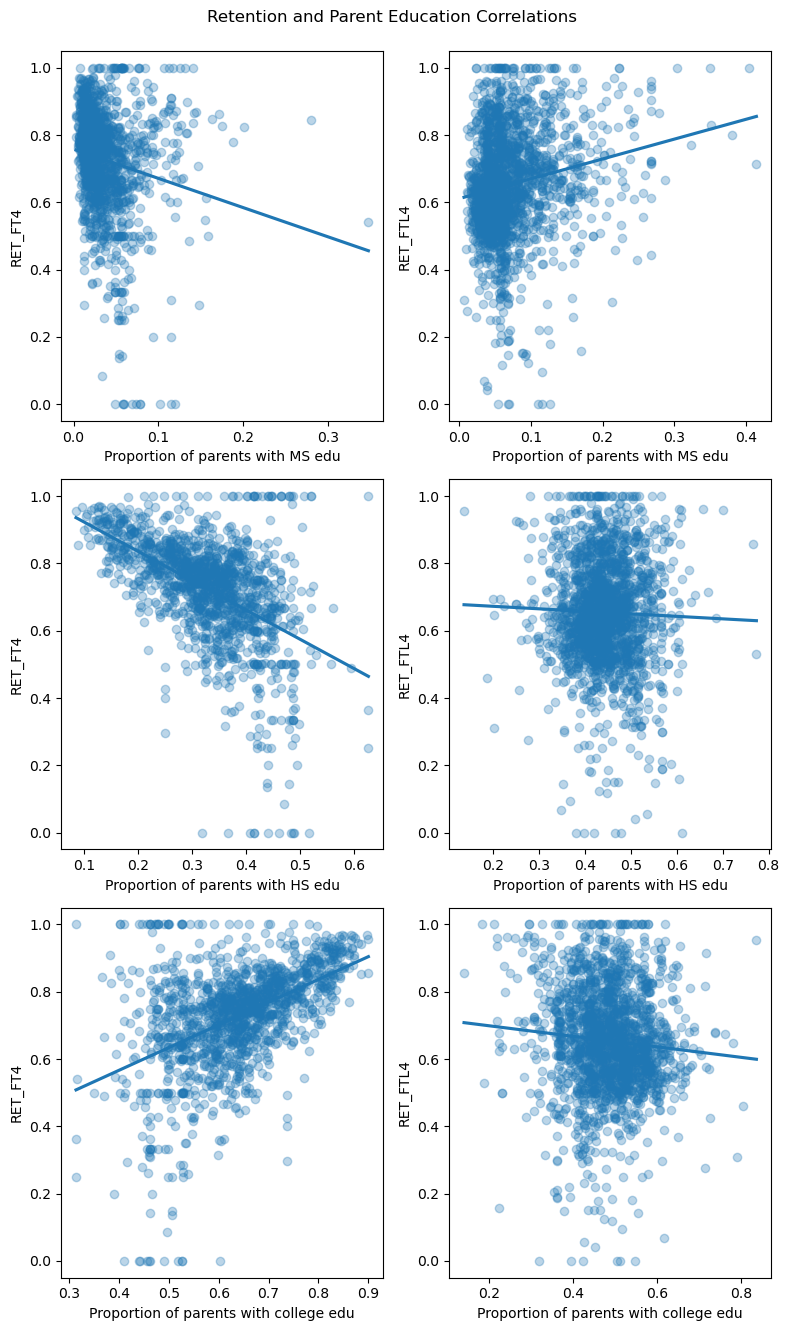

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(8, 13))
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FT4", data = edu_no_PrivacySuppressed_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,0])
axs[0,0].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,0].get_position()
pos.y0 += .4
axs[0, 0].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,1])
axs[0,1].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,1].get_position()
pos.y0 += .4
axs[0, 1].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FT4", data = edu_no_PrivacySuppressed_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,0])
axs[1,0].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,1])
axs[1,1].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FT4", data = edu_no_PrivacySuppressed_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,0])
axs[2,0].set_xlabel("Proportion of parents with college edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,1])
axs[2,1].set_xlabel("Proportion of parents with college edu")
fig.subplots_adjust(hspace=.2)
fig.tight_layout()
fig.suptitle("Retention and Parent Education Correlations ", y= 1.02);

Here we see that parents' middle school education seems have a nonlinear weak relationship with student retention. Parents' highschool and college education seem to be very weakly correlated with retention at less than 4 year institutions.

However, Parents' highschool and college education seems to be strongly correlated with a clear linear relationship with retention at 4 year institutions. Highschool education appears to have a negative correlation while college education has a positive correlationship. This may be because of confounding factors, but the association is clear.

**Based on this, we should include parent HS and college education ```PAR_ED_PCT_HS``` and ```PAR_ED_PCT_PS``` in our final analysis.**

This approach forces us to remove lots of the data. Instead, we can remove all indices with PrivacySuppressed or nulls for each combination of parent education (```PAR_ED_PCT_MS```, ```PAR_ED_PCT_HS```, ```PAR_ED_PCT_PS```) with student retention (```RET_FT4```, ```RET_FTL4```). 

This results in a unique subsample for each combination making their results less comparable, but the samples have more data in them making each test possible more representative of the fully sample.

In [12]:
#select all indices with "PrivacySuppressed" in them for each column individually
edu_indiv_PrivacySuppressed_indices = data[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].\
    apply(lambda col: col.astype(str).str.match("PrivacySuppressed"))

#remove those indices to get sample for each parent education and student retention feature combo
edu_no_PrivacySuppressed_MS_ft4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_MS]\
    [["PAR_ED_PCT_MS", "RET_FT4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_HS_ft4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_HS]\
    [["PAR_ED_PCT_HS", "RET_FT4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_PS_ft4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_PS]\
    [["PAR_ED_PCT_PS", "RET_FT4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_MS_ftl4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_MS]\
    [["PAR_ED_PCT_MS", "RET_FTL4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_HS_ftl4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_HS]\
    [["PAR_ED_PCT_HS", "RET_FTL4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_PS_ftl4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_PS]\
    [["PAR_ED_PCT_PS", "RET_FTL4"]].\
    dropna().\
    astype(float)

#check how large our samples are (note that they are larger)
print("One of our samples now has size: ", len(edu_no_PrivacySuppressed_PS_ftl4))

One of our samples now has size:  2538


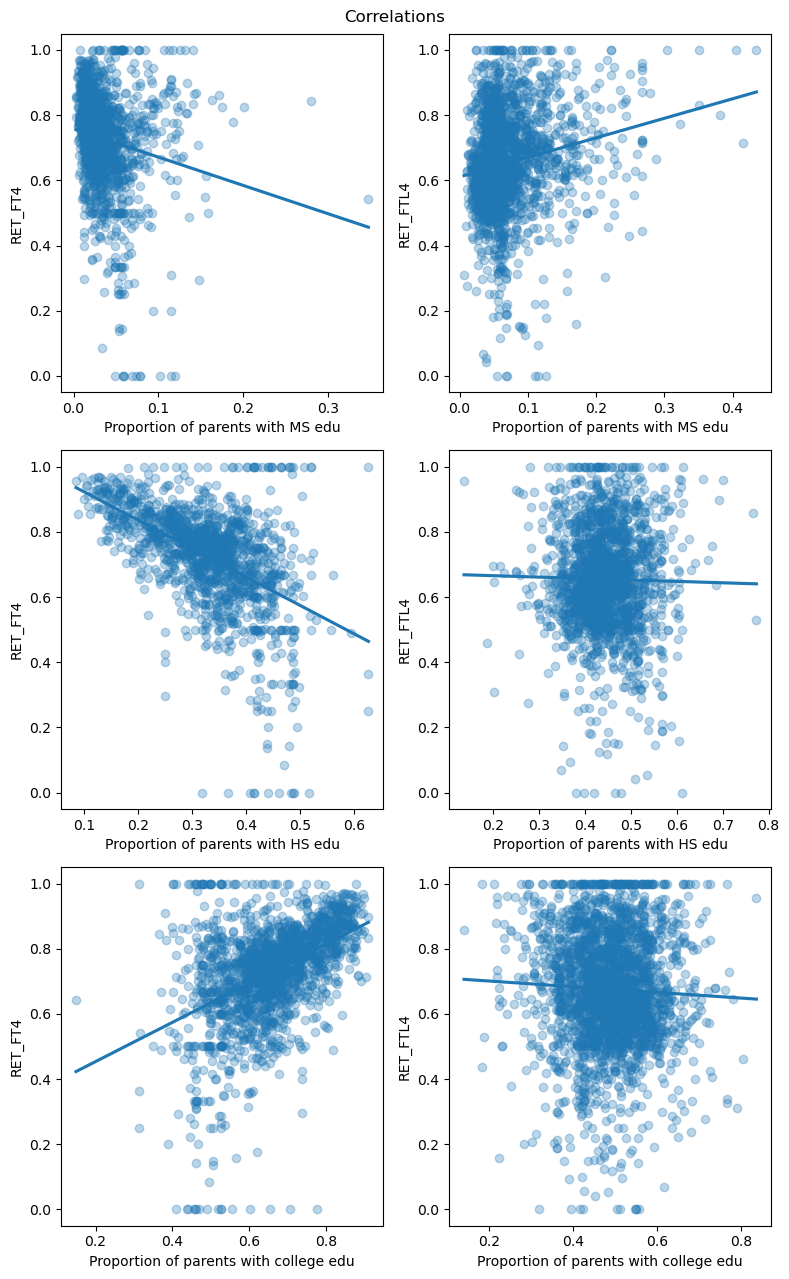

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(8, 13))
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FT4", data = edu_no_PrivacySuppressed_MS_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,0])
axs[0,0].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,0].get_position()
pos.y0 += .25
axs[0, 0].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_MS_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,1])
axs[0,1].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,1].get_position()
pos.y0 += .25
axs[0, 1].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FT4", data = edu_no_PrivacySuppressed_HS_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,0])
axs[1,0].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_HS_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,1])
axs[1,1].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FT4", data = edu_no_PrivacySuppressed_PS_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,0])
axs[2,0].set_xlabel("Proportion of parents with college edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_PS_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,1])
axs[2,1].set_xlabel("Proportion of parents with college edu")
fig.tight_layout()
fig.suptitle("Correlations");
plt.savefig('figures/parent_edu_corr.png')

**We get roughly the same results as with the previous method, with parents' college education being strongly positively correlated with retention at 4 year institutions and parents' highschool education being negatively correlated. This affirms that we should be using these variables in our final analysis of student retention.**